# 220511 DB species subgroup distance plots draft

In [1]:
from pathlib import Path
from types import SimpleNamespace

In [2]:
import pandas as pd
import numpy as np
import h5py as h5
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from gambit.db import Taxon, load_genomeset

In [4]:
%matplotlib inline

## Setup

In [5]:
DATESTR = '220511'
NBNAME = DATESTR + '-db-species-subgroup-dist-plots-draft'

In [6]:
wf_tmp_dir = Path('/home/jared/code/gambit/gambit-publication/intermediate-data/db-pw-dists')

infiles = dict(
    genomes='/home/jared/projects/gambit/data/databases/refseq-curated/1.0-beta2/gambit-genomes-1.0b2-211111.db',
    # chunks_summary=wf_tmp_dir / 'chunks.csv',
    chunk_taxa=wf_tmp_dir / 'chunk-taxa.csv',
    chunk_genomes_dir=wf_tmp_dir / 'chunks',
    dists_dir=wf_tmp_dir / 'dists',
    overlaps='data-processed/220507-db-pw-dists/220507-db-overlaps.csv',
    dists_summary='data-processed/220507-db-pw-dists/220507-db-dists-summary.csv',
)

In [7]:
processed_out = Path('data-processed/') / NBNAME
processed_out.mkdir(exist_ok=True)

## Code

In [8]:
def fix_nullable_int_col(df, col):
    """Fix column containing ints/Nones after Pandas coerces it to float data type."""
    df[col] = np.asarray([None if pd.isnull(v) else int(v) for v in df[col]], dtype=object)

## Load data

### Database

In [9]:
session, gset = load_genomeset(infiles['genomes'])

In [10]:
taxa_by_id = {t.id: t for t in gset.taxa}

### Distance matrix chunks

In [11]:
chunk_taxa = pd.read_csv(infiles['chunk_taxa'], index_col=0)
fix_nullable_int_col(chunk_taxa, 'ncbi_id')

nchunks = chunk_taxa['chunk'].max() + 1

In [12]:
chunk_genomes = pd.concat(
    [
        pd.read_csv(infiles['chunk_genomes_dir'] / f'{i}.csv', index_col=0)
        for i in range(nchunks)
    ],
    keys=range(nchunks),
    names=['chunk'],
)

In [13]:
chunk_pairs = [(i, j) for i in range(nchunks) for j in range(i, nchunks)]

In [14]:
dmat_files = {(i, j): infiles['dists_dir'] / f'{i}-{j}.h5' for i, j in chunk_pairs}

### Last notebook

In [15]:
dists_df = pd.read_csv(infiles['dists_summary'], index_col=0)
dists_df.index.name = 'taxon_id'

In [16]:
overlaps_df = pd.read_csv(infiles['overlaps'], index_col=[0, 1])

## Species to plot

In [17]:
subgroup_species = {taxon.parent for taxon in gset.taxa if 'subgroup' in taxon.name}

In [18]:
plot_df = dists_df.loc[[t.id for t in subgroup_species], ['name', 'diameter', 'min_inter_dist', 'min_inter_taxon_id', 'min_inter_taxon_name']]

In [19]:
_n_overlap = overlaps_df.groupby(['in_id']).size()
_n_overlap.index.name = 'taxon_id'

plot_df['n_overlap_leaves'] = _n_overlap

In [20]:
plot_df

,name,diameter,min_inter_dist,min_inter_taxon_id,min_inter_taxon_name,n_overlap_leaves
taxon_id,,,,,,
1304,Prochlorococcus marinus,0.998967,0.994065,1581,Arcobacter butzleri,440
1910,Shigella dysenteriae,0.560220,0.204837,1913,Shigella boydii subgroup 1,4
647,Pseudomonas savastanoi,0.489886,0.297822,1898,Pseudomonas amygdali subgroup 2,2
1917,Escherichia coli,0.682538,0.364887,1912,Shigella sonnei,1
1909,Shigella boydii,0.296933,0.204837,1916,Shigella dysenteriae subgroup 2,1
1477,Bacillus amyloliquefaciens,0.456449,0.347348,1476,Bacillus velezensis,1
634,Pseudomonas syringae,0.914961,0.295101,1899,Pseudomonas amygdali subgroup 3,5
851,Enterobacter cloacae,0.665320,0.289390,1880,Enterobacter hormaechei subgroup 2,1
655,Pseudomonas amygdali,0.522444,0.295101,1905,Pseudomonas syringae subgroup 4,2


In [21]:
toremove = plot_df.index[plot_df['n_overlap_leaves'] > 5]
plot_df.loc[toremove]

,name,diameter,min_inter_dist,min_inter_taxon_id,min_inter_taxon_name,n_overlap_leaves
taxon_id,,,,,,
1304,Prochlorococcus marinus,0.998967,0.994065,1581,Arcobacter butzleri,440
1551,Clostridium botulinum,0.994352,0.822058,1555,Clostridium sporogenes,30


In [22]:
plot_df.drop(toremove, inplace=True)

## Load distances

In [23]:
def _get_taxon(t):
    return t if isinstance(t, Taxon) else taxa_by_id[t]

def get_taxon_chunk(taxon):
    return chunk_taxa.loc[_get_taxon(taxon).root().id, 'chunk']

def get_genome_indices_direct(chunk, tids, asint=True):
    bools = np.in1d(chunk_genomes.loc[chunk, 'taxon_id'], tids)
    return np.flatnonzero(bools) if asint else bools

def get_genome_indices_subtree(chunk, taxon, asint=True):
    subtree_tids = [t.id for t in taxon.traverse()]
    return get_genome_indices_direct(chunk, subtree_tids, asint)


def load_matrix_subset(dataset, rows, cols):
    assert dataset.ndim == 2
    rows = np.asarray(rows)
    cols = np.asarray(cols)
    assert rows.ndim == 1
    assert cols.ndim == 1
    
    if rows.dtype.kind == 'b':
        rows = np.flatnonzero(rows)
    elif rows.dtype.kind not in 'ui':
        raise ValueError('Rows dtype')
        
    if cols.dtype.kind == 'b':
        ncol = cols.sum()
    elif cols.dtype.kind in 'ui':
        ncol = len(cols)
    else:
        raise ValueError('Cols dtype')
        
    out = np.empty((len(rows), ncol), dtype=dataset.dtype)
    for i, r in enumerate(rows):
        out[i, :] = dataset[r, cols]
        
    return out


def load_matrix_triu(dataset, indices):
    assert dataset.ndim == 2
    assert indices.ndim == 1
    assert indices.dtype.kind in 'ui'
    n = len(indices)
    npairs = n * (n - 1) // 2
    
    out = np.empty(npairs, dtype=dataset.dtype)
    
    start = 0
    for i, ix in enumerate(indices):
        l = n - i - 1
        out[start:start + l] = dataset[ix, indices[i+1:]]
        start += l
        
    assert start == npairs
    return out
        

def load_inter_dists(taxon1, taxon2, flat=False):
    taxon1 = _get_taxon(taxon1)
    taxon2 = _get_taxon(taxon2)
    chunk1 = get_taxon_chunk(taxon1)
    chunk2 = get_taxon_chunk(taxon2)
    
    if chunk1 > chunk2:
        taxon1, taxon2 = taxon2, taxon1
        chunk1, chunk2 = chunk2, chunk1
        flipped = True
    else:
        flipped = False
        
    indices1 = get_genome_indices_subtree(chunk1, taxon1)
    indices2 = get_genome_indices_subtree(chunk2, taxon2)
    
    with h5.File(dmat_files[chunk1, chunk2]) as file:
        dmat = file['dmat']
        dists = load_matrix_subset(dmat, indices1, indices2)
        
        if flat:
            return dists.flatten()
        return dists.t if flipped else dists
    

def load_intra_dists(taxon):
    taxon = _get_taxon(taxon)
    chunk = get_taxon_chunk(taxon)
    indices = get_genome_indices_subtree(chunk, taxon)
    
    with h5.File(dmat_files[chunk, chunk]) as file:
        dmat = file['dmat']
        return load_matrix_triu(dmat, indices)

In [24]:
def make_species_data(taxon):
    data = SimpleNamespace()
    data.taxon = _get_taxon(taxon)

    data.subgroups = list(data.taxon.children)
    assert data.subgroups
    assert all(sg.isleaf() for sg in data.subgroups)

    data.out_taxa = [taxa_by_id[tid] for tid in overlaps_df.loc[data.taxon.id].index]
    # assert all(taxon.isleaf() for taxon in data.out_taxa)
    
    data.intra_pairs = [(sg.id, sg.id) for sg in data.subgroups]
    data.inter_pairs = [(sg1.id, sg2.id) for i, sg1 in enumerate(data.subgroups) for sg2 in data.subgroups[i+1:]]
    data.out_pairs = [(sg.id, out.id) for sg in data.subgroups for out in data.out_taxa]
    
    data.species_pairs = data.intra_pairs + data.inter_pairs
    # data.all_pairs = intra_species_pairs + inter_species_pairs

    data.dists = dict()

    for i, sg1 in enumerate(data.subgroups):
        data.dists[sg1.id, sg1.id] = load_intra_dists(sg1)

    for t1, t2 in data.inter_pairs + data.out_pairs:
        data.dists[t1, t2] = data.dists[t2, t1] = load_inter_dists(t1, t2, True)
        
    return data

In [25]:
species_data = [make_species_data(tid) for tid in tqdm(plot_df.index)]

  0%|          | 0/15 [00:00<?, ?it/s]

## Plot

In [26]:
# palette = sns.color_palette('Set1')
palette = sns.color_palette(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [27]:
def axis_legend_handles(ax):
    return {l: h for h, l in zip(*ax.get_legend_handles_labels())}

def figure_legend_handles(fig):
    d = dict()
    for ax in fig.axes:
        d.update(axis_legend_handles(ax))
    return d
    
def make_legend(fig, relabel, **kw):
    d = figure_legend_handles(fig)
    
    old_labels, new_labels = zip(*relabel)
    handles = [d[l] for l in old_labels]

    return fig.legend(handles, new_labels, **kw)

In [28]:
def plot_hist(ax, x, color, fill=True, **kw):
    sns.histplot(
        x=x,
        ax=ax,
        element='step',
        color=color,
        stat='probability',
        # line_kws=dict(lw=2),
        # fill=fill,
        alpha=.2 if fill else 0,
        lw=1 if fill else 2,
        **kw,
    )

In [29]:
def make_hists(data):
    
    # Set up plot
    h = (1 + len(data.subgroups)) * 2.5
    fig, axs = plt.subplots(len(data.subgroups) + 1, 1, figsize=(18, h), sharex=True)
    fig.suptitle(data.taxon.name, fontsize='x-large')

    # Full species subplot
    axs[0].set_title('Combined')
    sp_dists = np.concatenate([data.dists[p] for p in data.species_pairs])
    plot_hist(axs[0], sp_dists, color=palette[0], label='sp_intra')

    for i, out in enumerate(data.out_taxa):
        out_dists = np.concatenate([data.dists[sg.id, out.id] for sg in data.subgroups])
        plot_hist(axs[0], out_dists, color=palette[i+2], label=f'sp_out_{out.id}', fill=False)
        
    # Subgroup subplots
    for i, sg in enumerate(data.subgroups):
        ax = axs[i + 1]
        ax.set_title(f'Subgroup {i+1} (n={sg.genomes.count()})')
        
        plot_hist(ax, data.dists[sg.id, sg.id], color=palette[0], label=f'sg{i}_intra')

        ax.axvline(sg.distance_threshold, color=palette[0], lw=2, linestyle='dashed', label=f'sg{i}_threshold')

        out_dists = np.concatenate([data.dists[sg.id, sg2.id] for sg2 in data.subgroups if sg is not sg2])
        plot_hist(ax, out_dists, color=palette[1], label=f'sg{i}_inter')

        for j, out in enumerate(data.out_taxa):
            plot_hist(ax, data.dists[sg.id, out.id], color=palette[j+2], label=f'sg{i}_out_{out.id}', fill=False)
            
    # Finish fugure
    axs[-1].set_xlim(0, None)
    fig.tight_layout(rect=(0, .05, 1, 1))
    make_legend(
        fig,
        [
            ('sp_intra', 'Species/subgroup intra'),
            ('sg0_inter', 'Subgroup inter'),
            ('sg0_threshold', 'Subgroup Threshold'),
            *((f'sg0_out_{out.id}', out.name) for out in data.out_taxa),
        ],
        loc='lower center',
        ncol=6,
    )
    
    return fig

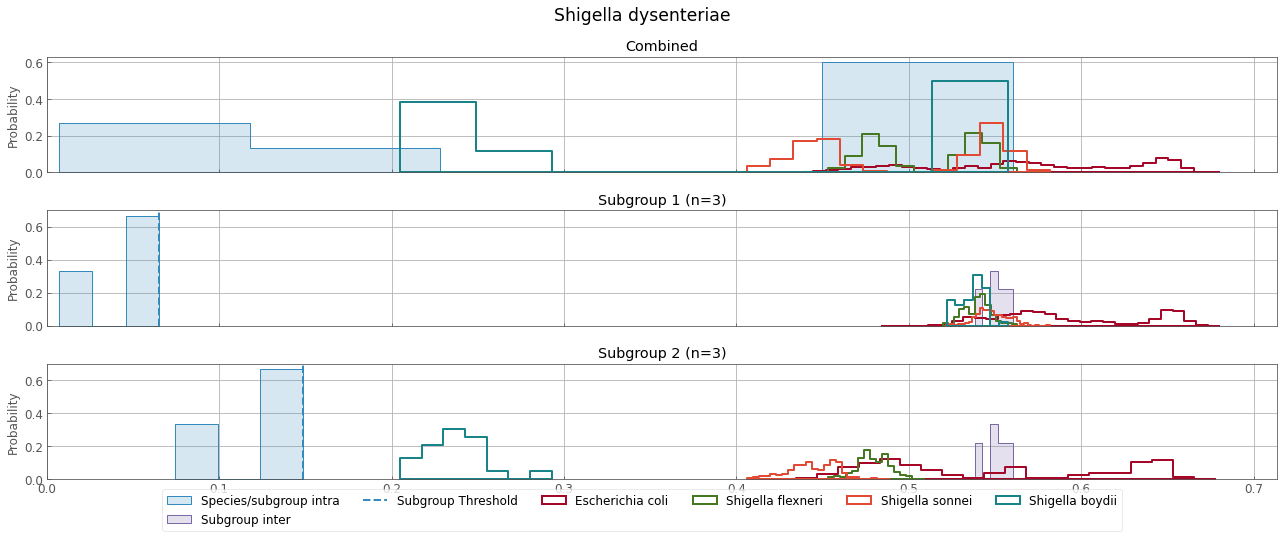

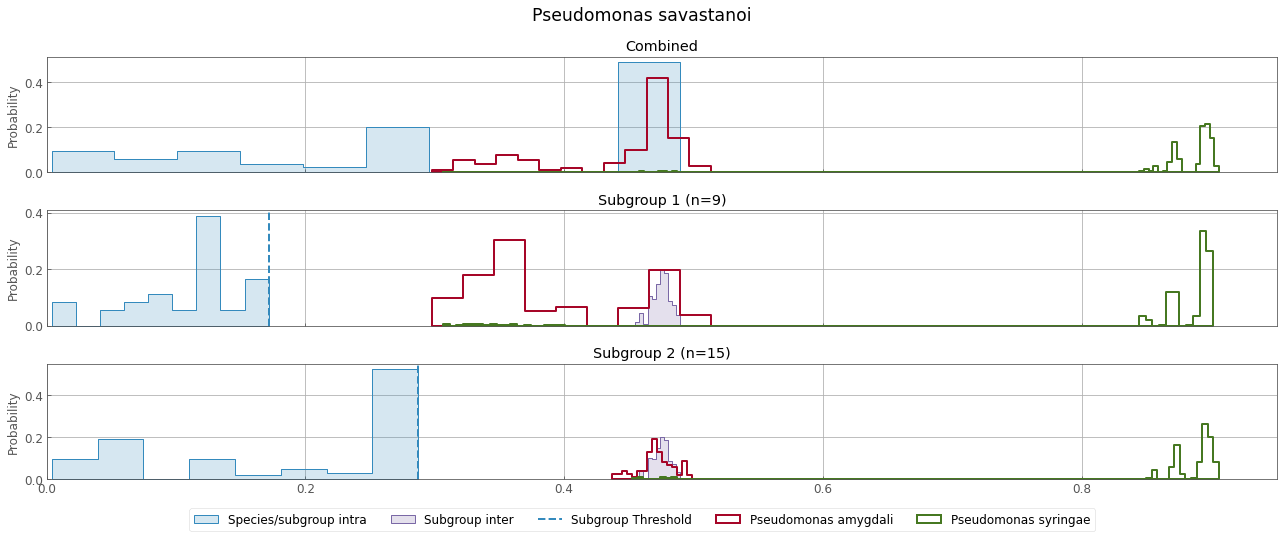

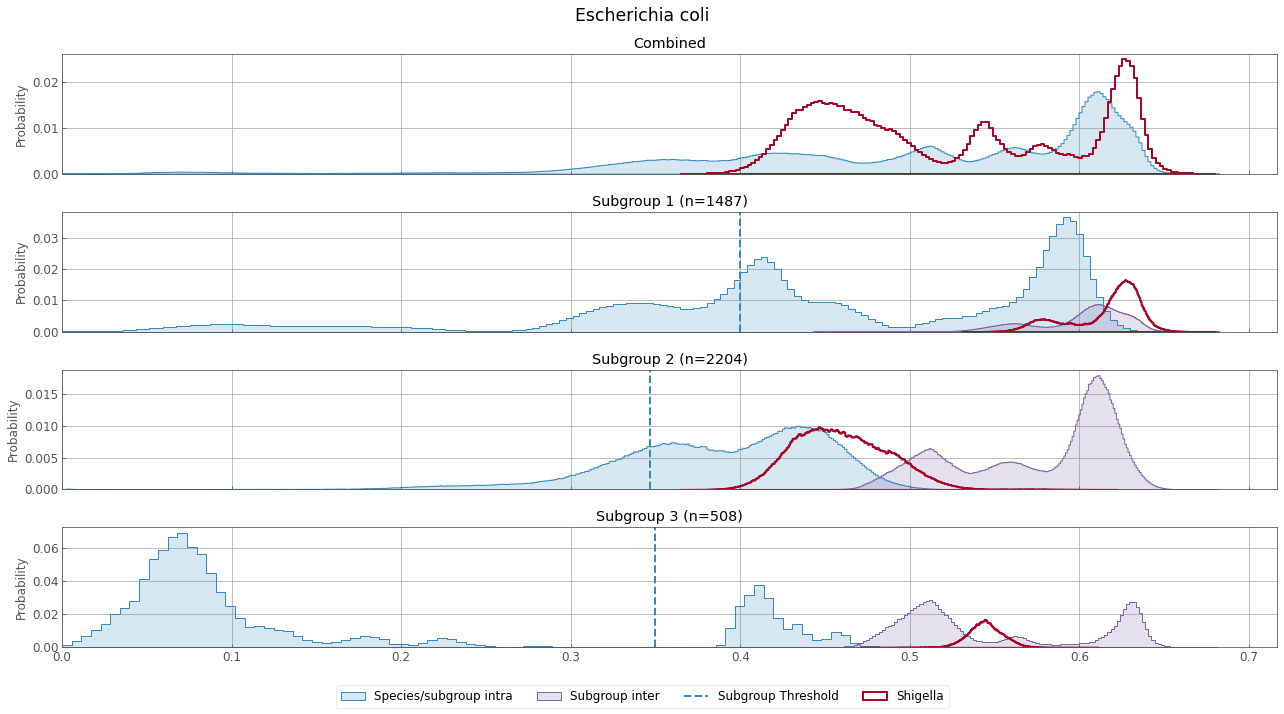

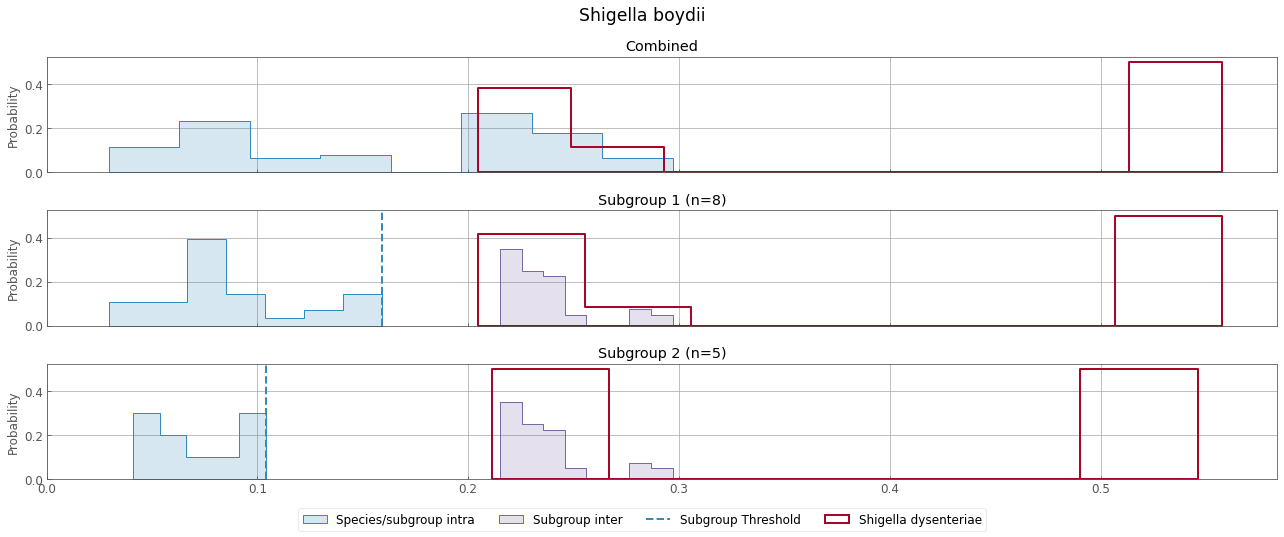

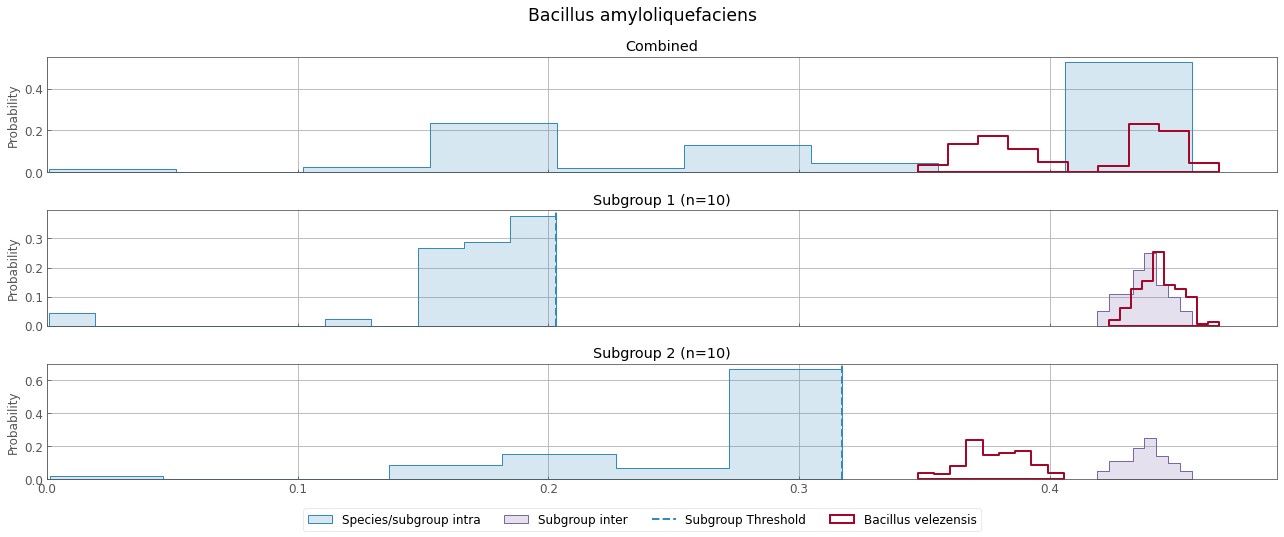

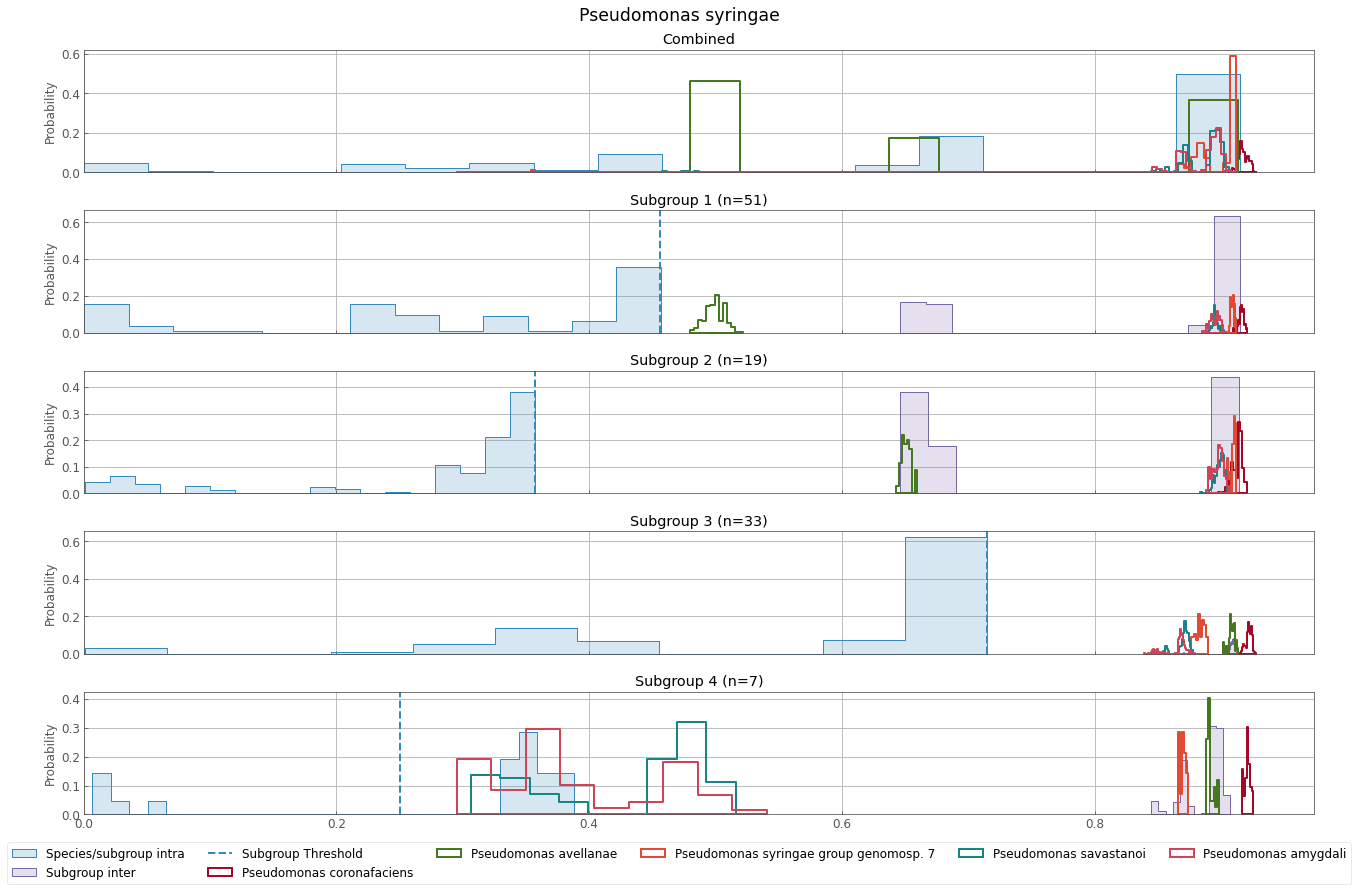

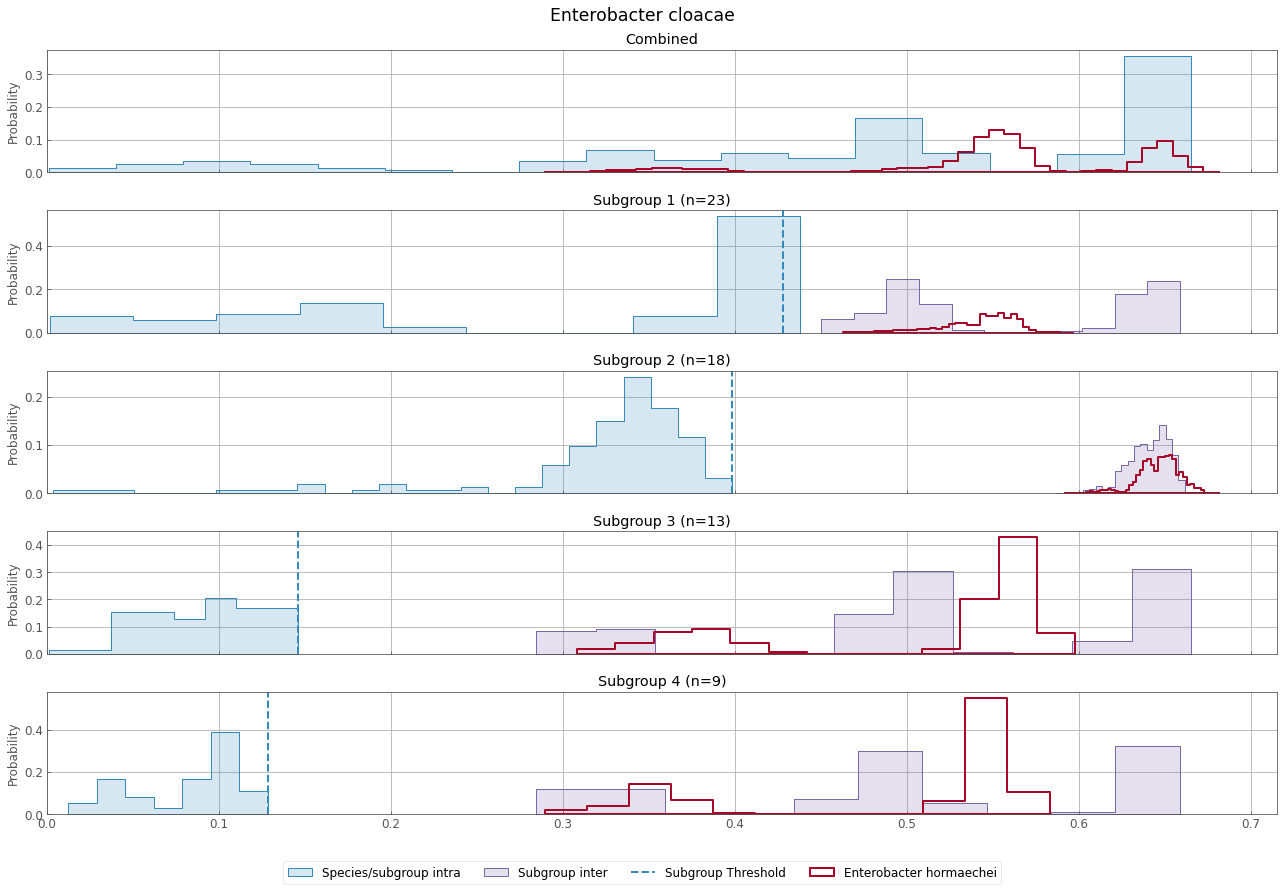

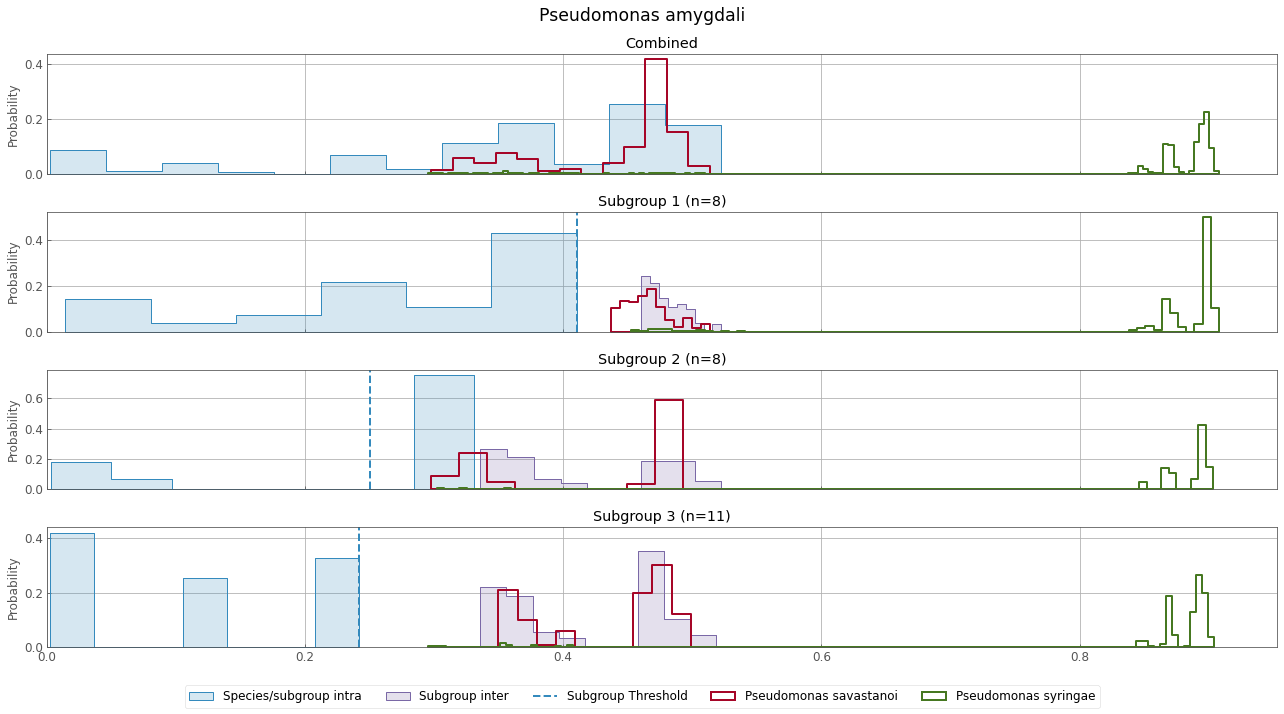

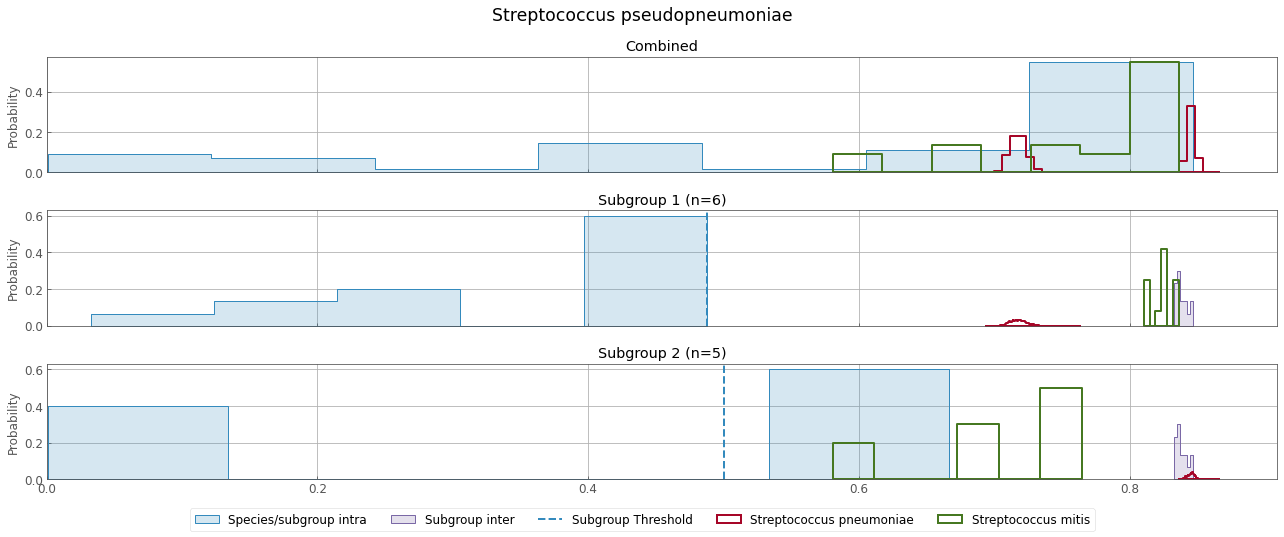

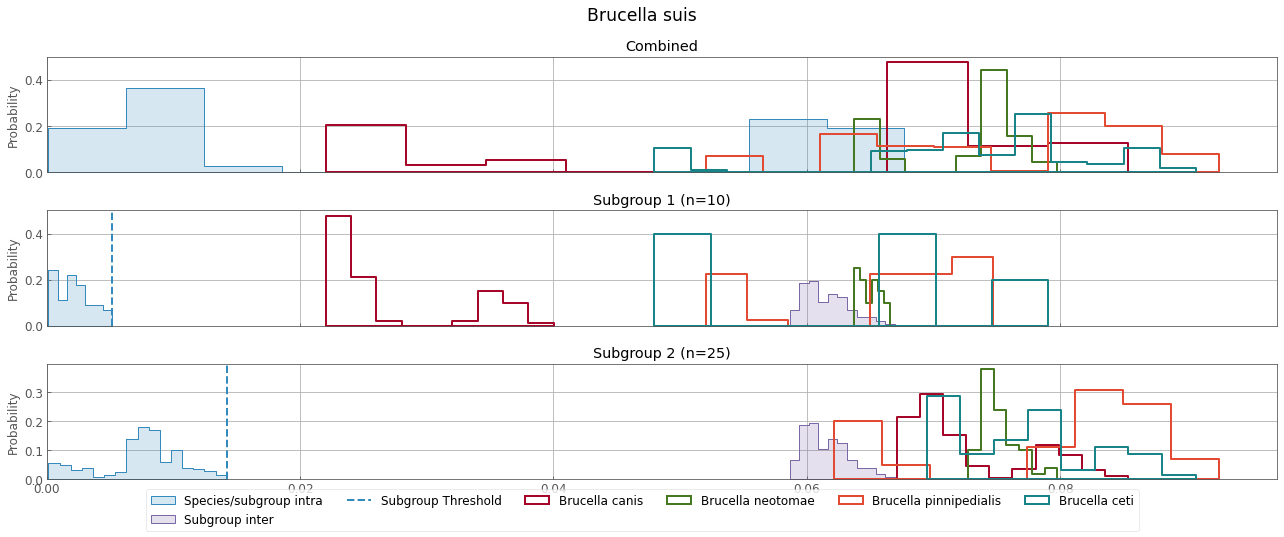

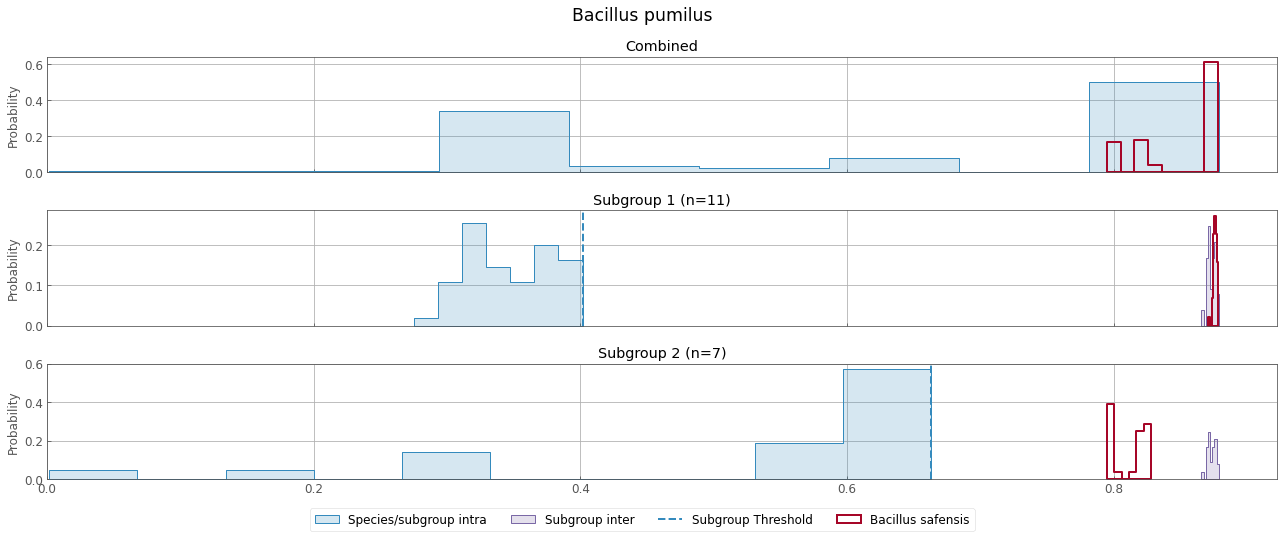

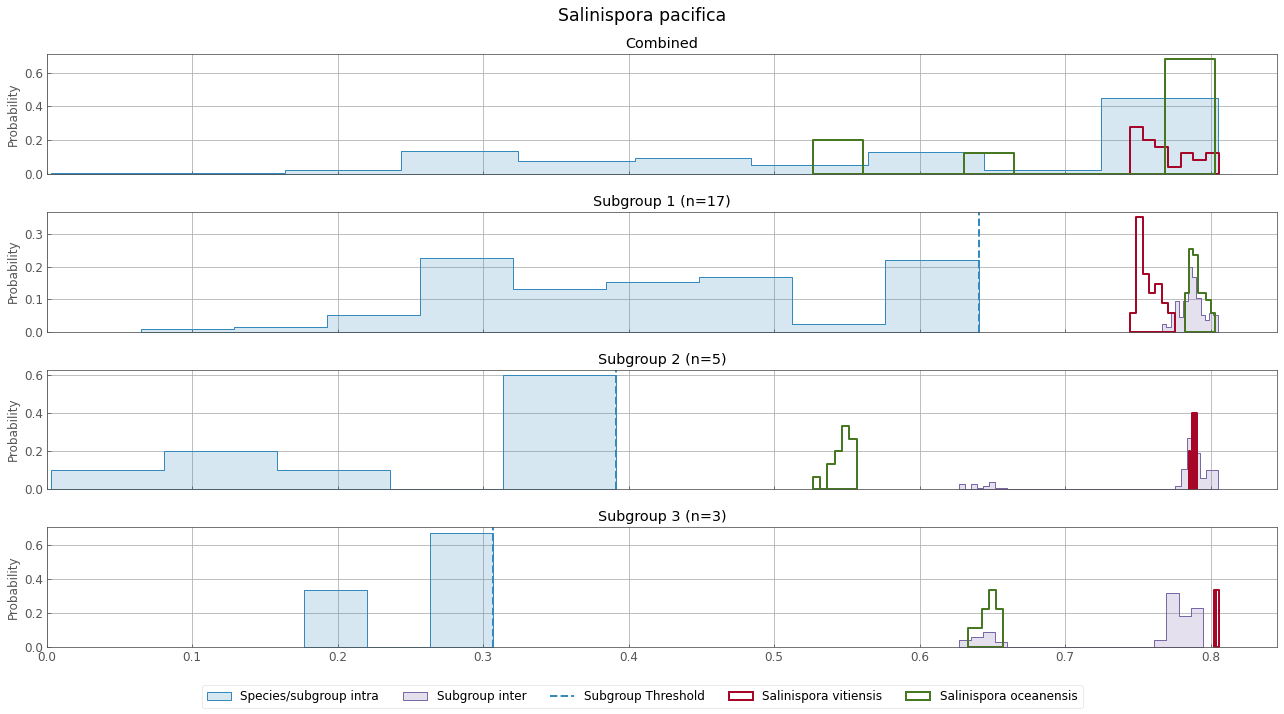

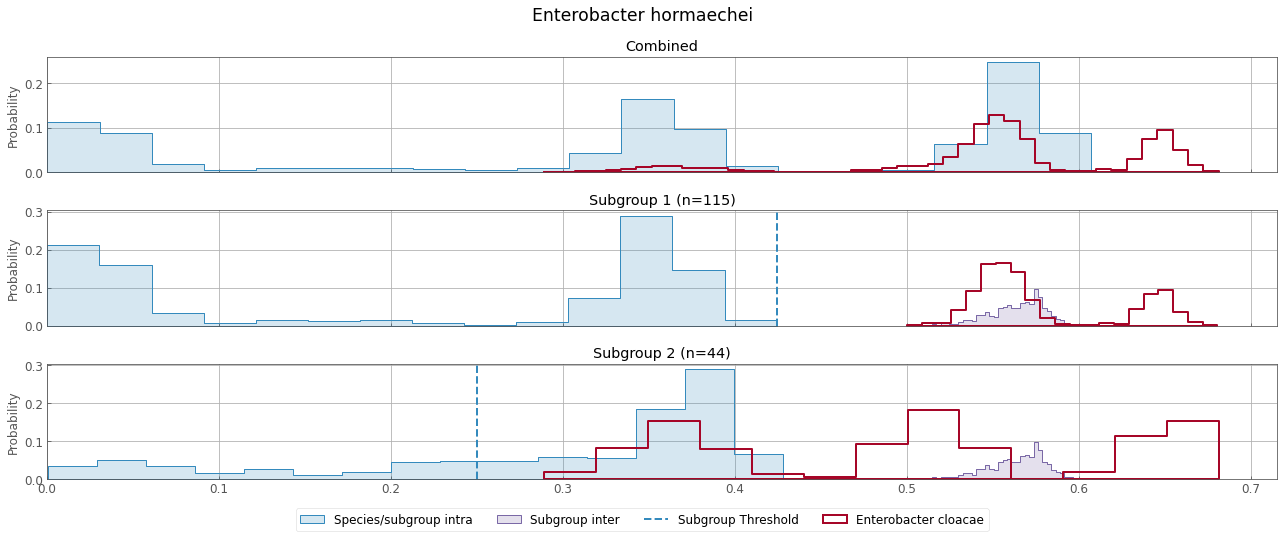

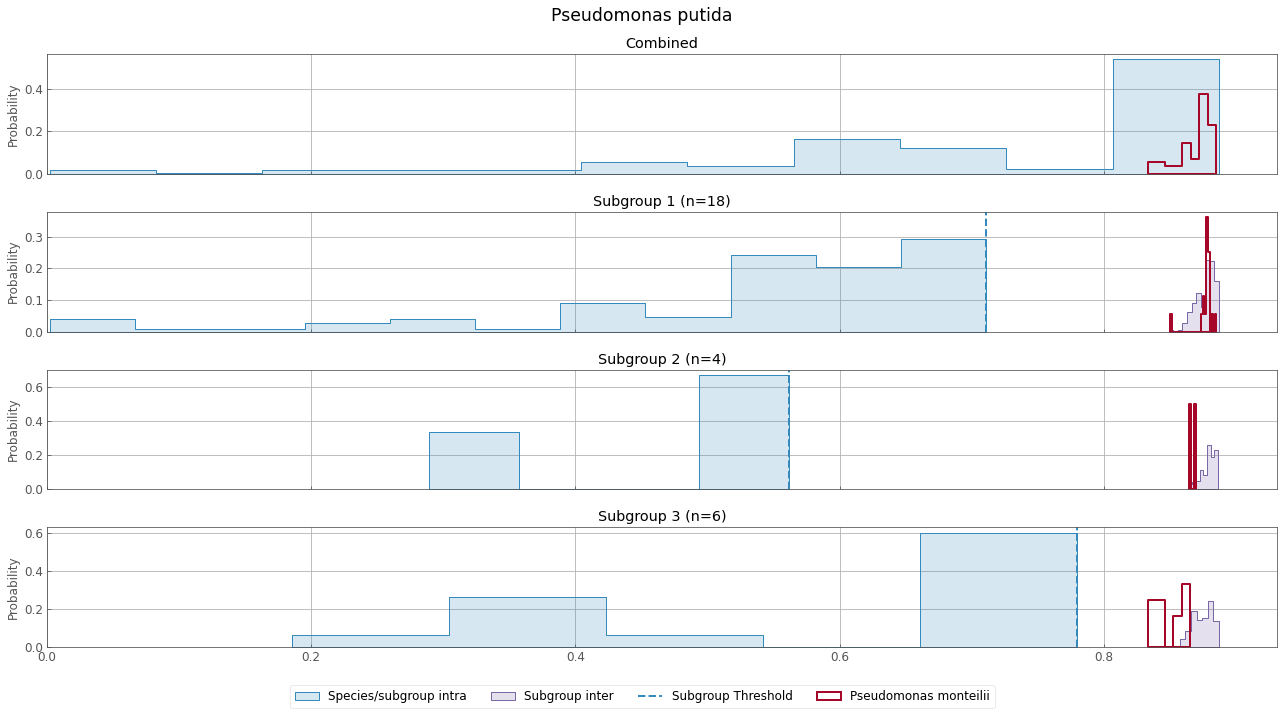

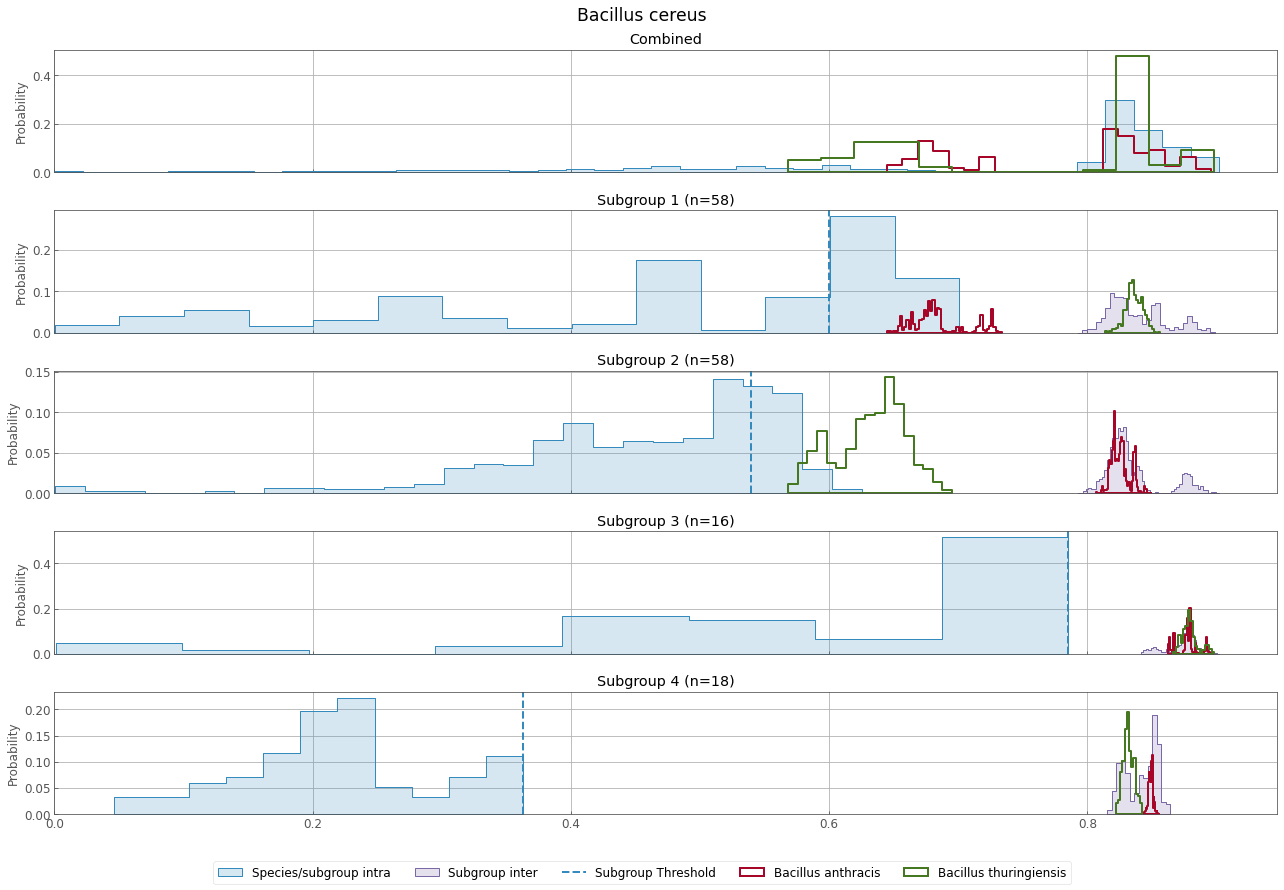

In [30]:
for data in species_data:
    fig = make_hists(data)
    name = data.taxon.name.replace(' ', '_')
    fig.savefig(processed_out / f'{DATESTR}-{name}-subgroup-dists.png', dpi=300)